In [1]:
from base64 import encode
from tkinter import font
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image

In [2]:
cat_train_path="./input/cat-and-dog/training_set/cats/"
cat_test_path="./input/cat-and-dog/test_set/cats/"

In [3]:
cat_train=[]
for filename in os.listdir(cat_train_path):
    if filename.endswith(".jpg"):
        img=image.load_img(cat_train_path+filename,target_size=(128,128))
        cat_train.append(image.img_to_array(img))
cat_train=np.array(cat_train)

cat_test=[]
for filename in os.listdir(cat_test_path):
    if filename.endswith(".jpg"):
        img=image.load_img(cat_test_path+filename,target_size=(128,128))
        cat_test.append(image.img_to_array(img))
cat_test=np.array(cat_test)

print("cat_train",cat_train.shape)
print("cat_test",cat_test.shape)

cat_train (4000, 128, 128, 3)
cat_test (1011, 128, 128, 3)


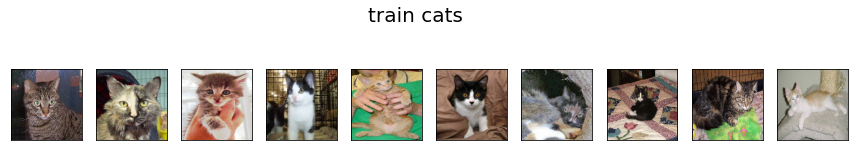

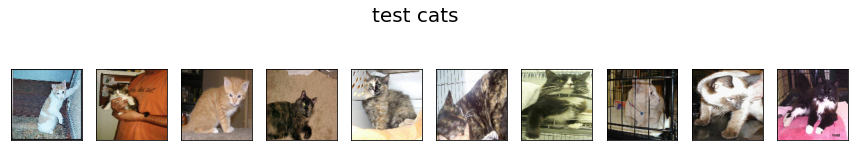

In [4]:
#Visualize the cats
def show_cat_data(X,n=10,title=""):
    plt.figure(figsize=(15,5))
    for i in range(n):
        ax=plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title,fontsize=20)

show_cat_data(cat_train,title="train cats")
show_cat_data(cat_test,title="test cats")

In [5]:
#Build the cat Autoencoder
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

cat_AE = Model(input_layer, output_layer)
cat_AE.compile(optimizer='adam', loss='mse')
cat_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584   

In [6]:
# Train the cat Autoencoder
cat_AE.fit(cat_train, cat_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(cat_test, cat_test))

Epoch 1/30
125/125 [==============================] - 7s 29ms/step - loss: 3072.2180 - val_loss: 1122.7146
Epoch 2/30
125/125 [==============================] - 3s 25ms/step - loss: 993.8019 - val_loss: 943.4354
Epoch 3/30
125/125 [==============================] - 3s 22ms/step - loss: 829.0310 - val_loss: 765.6660
Epoch 4/30
125/125 [==============================] - 3s 22ms/step - loss: 710.7740 - val_loss: 692.6241
Epoch 5/30
125/125 [==============================] - 3s 24ms/step - loss: 661.4327 - val_loss: 656.8038
Epoch 6/30
125/125 [==============================] - 3s 23ms/step - loss: 633.4386 - val_loss: 630.6172
Epoch 7/30
125/125 [==============================] - 3s 22ms/step - loss: 610.0414 - val_loss: 608.2457
Epoch 8/30
125/125 [==============================] - 3s 23ms/step - loss: 594.2165 - val_loss: 601.2421
Epoch 9/30
125/125 [==============================] - 3s 24ms/step - loss: 579.7740 - val_loss: 583.4665
Epoch 10/30
125/125 [==============================] 

In [7]:
#Save model
cat_AE.save("cat_AE.h5")

In [8]:
#Make a model to get the encoded representation (i.e. intermediate layer output) for a given cat image.
get_encoded_cat = Model(inputs=cat_AE.input, outputs=cat_AE.get_layer("CODE").output)

In [9]:
#Get the encoded cats
encoded_cat=get_encoded_cat.predict(cat_test)
encoded_cat = encoded_cat.reshape((len(cat_test), 16*16*8))
encoded_cat.shape

(1011, 2048)

In [10]:
#Get the reconstructed cats
reconstructed_cats = cat_AE.predict(cat_test)

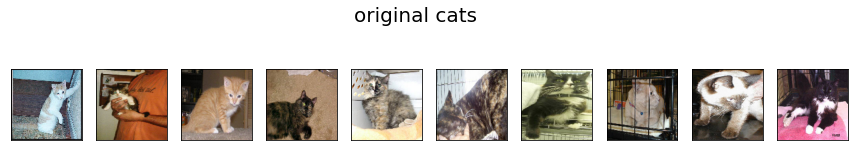

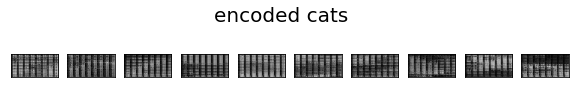

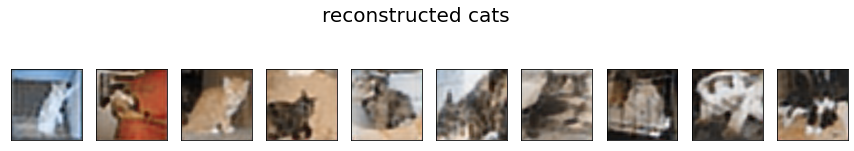

In [11]:
#Visualize the results on test set
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)
    
show_cat_data(cat_test, title="original cats")
show_data(encoded_cat, height=32, width=64, title="encoded cats")
show_cat_data(reconstructed_cats, title="reconstructed cats")